# PHYS366: Statistical Methods in Astrophysics


# Lesson 3: Inference in Practice: PDF Characterization

### Goals for this session:

* Linear problems: General solution + short cuts. When and why do these short cuts work?
* Introduction to Monte Carlo Methods
* Convergence tests

Adapted from [straight line notebook](https://github.com/drphilmarshall/LearningInference/blob/master/straightline.ipynb) by Phil Marshall and Dustin Lang
#### Related reading:
* Ivezic Ch. 8.1, 8.2, 8.8
* MacKay Ch. 27
* Ch. 2 of [Phil's thesis](http://www.slac.stanford.edu/~pjm/Site/CV_files/Marshall_PhDthesis.pdf)

# The Data Set
Today we will explore different methods to fit a model to data, and discuss the advantages and limitations of these methods. For simplicity, we'll just load a synthetic set of points.

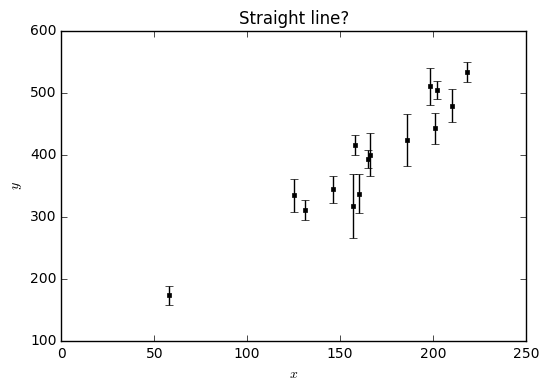

In [52]:
import numpy as np
from straightline_utils import *
%matplotlib inline
from matplotlib import rcParams
rcParams['savefig.dpi'] = 100
(x,y,sigmay) = get_data_no_outliers()
plot_yerr(x, y, sigmay)

# Bayesian Solution: Posterior distribution of model parameters

This looks like data points scattered around a straight line,

$y = b + m x$.

If the error distribution in $y$ is Gaussian, the data likelihood for a specific linear model $(m,b)$ is given by

$P(\{x_i,y_i,\sigma_{y_i}\}|(m,b)) = \Pi_i\frac{1}{\sqrt{2\pi}\sigma_{y_i}} \exp[-1/2(y_i-(b+m x_i) )^2/\sigma_{y_i}^2]$.

Assuming a flat prior PDF for the model parameters, the posterior PDF of model parameters $(m, b)$ is directly proportional to the data likelihood. We can test this model by determining the parameter log-likelihood

$\ln(L((m,b)|\{x_i,y_i,\sigma_{y_i}\})\propto \sum_i -1/2(y_i-(b+m x_i) )^2/\sigma_{y_i}^2$

on a parameter grid, which captures the uncertainty in the model parameters given the data. For simple, 2-dimensional parameter spaces like this one, evaluating on a grid is not a bad way to go.

In [71]:
def straight_line_log_likelihood(x, y, sigmay, m, b):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y_t = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept

    Returns: scalar log likelihood
    '''
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / sigmay**2))
    
def straight_line_log_prior(m, b):
    return 0.
    
def straight_line_log_posterior(x,y,sigmay, m,b):
    return (straight_line_log_likelihood(x,y,sigmay, m,b) +
            straight_line_log_prior(m, b))


Grid maximum posterior values: 27.0 2.28888888889


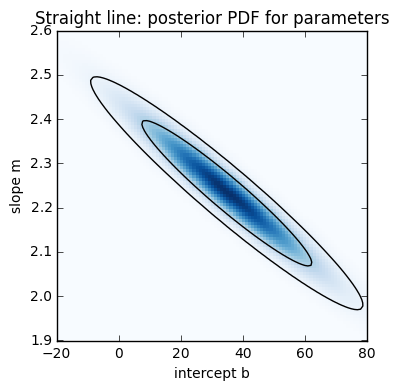

In [72]:
# Evaluate log P(m,b | x,y,sigmay) on a grid.
# Set up grid
mgrid = np.linspace(mlo, mhi, 100)
bgrid = np.linspace(blo, bhi, 101)
log_posterior = np.zeros((len(mgrid),len(bgrid)))
# Evaluate log probability on grid
for im,m in enumerate(mgrid):
    for ib,b in enumerate(bgrid):
        log_posterior[im,ib] = straight_line_log_posterior(x, y, sigmay, m, b)
# Convert to probability density and plot
posterior = np.exp(log_posterior - log_posterior.max())
plt.imshow(posterior, extent=[blo,bhi, mlo,mhi],cmap='Blues',
           interpolation='nearest', origin='lower', aspect=(bhi-blo)/(mhi-mlo),
           vmin=0, vmax=1)
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')

i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print 'Grid maximum posterior values:', bgrid[i], mgrid[j]

plt.title('Straight line: posterior PDF for parameters');
#plt.plot(b_ls, m_ls, 'w+', ms=12, mew=4);
plot_mb_setup();

## Short Cut #1: Linear Least Squares
An industry standard: find the slope $m_{\mathrm{LS}}$ and intercept $b_{\mathrm{LS}}$ that minimize the mean square, variance-weighted residual
$R^2(m,b) = \sum_i[y_i-(b+m x_i)]^2/\sigma_{y_i}^2$:

$(1)\,\, \frac{\partial R^2}{\partial b}|_{b_{\mathrm{LS}}} =0 = -2\sum_i[y_i-(b_{\mathrm{LS}}+m_{\mathrm{LS}} x_i) ]/\sigma_{y_i}^2$,   
$(2)\,\,\frac{\partial R^2}{\partial m}|_{m_{\mathrm{LS}}} = 0 = -2\sum_i [y_i-(b_{\mathrm{LS}}+m_{\mathrm{LS}} x_i )]x_i/\sigma_{y_i}^2$.


### Derive the solution for homoscedastic (i.e. $\sigma_i = \sigma$) data from (1) and (2)
* $\hat{b} = $
* $\hat{m} = $

### Least Squares as a Maximum-Likelihood Estimator
If the data are Gaussian distributed, _minimizing the variance weighted residual_ is equivalent to _maximizing the posterior_ and the least squares estimator is a Maximum Likelihood Estimator (MLE).

Deriving a MLE is a useful trick to remember, especially if you want an analytic expression. While MLEs are not optimal for finite samples, but have convenient limiting properties as the smaple size goes to infinity:

* _Consistency_: the estimator converges in probability to the true value  
* _Asymptotic normality_: as the sample size increases, the distribution of the MLE tends to the Gaussian distribution with true mean and covariance matrix equal to the inverse of the Fisher information matrix
* _Efficiency_: no consistent estimator has lower asymptotic mean squared error than the MLE

### Solution in Matrix form

With $\theta = (b,m)$ and $\mathbf{A}=\begin{bmatrix}1 & x_1\\ 1 & x_2\\ \vdots & \vdots \\ 1 & x_n\end{bmatrix}$  the residual is given by $R^2 = ||(\mathbf{y} - \mathbf{A} \theta)||^2 = \frac{1}{\sigma^2}(\mathbf{y} - \mathbf{A} \theta)^\tau  (\mathbf{y} - \mathbf{A} \theta)$

and Equations (1) and (2) can be written as
$\mathbf{A}^\tau \mathbf{A} \theta = \mathbf{A}^\tau \mathbf{y}$.

algebraically the solution is given by
$\hat{\theta} = \left(\mathbf{A}^\tau \mathbf{X}\right)^{-1}\mathbf{A}^\tau \mathbf{y}$, however this is not the numerically recommended implementation.

In the heteroscastic case, the matrix norm is in general instead given by the inverse data covariance. In the case of heteroscedastic, uncorrelated data, this amounts of to a rescaling $A_{i,.} \rightarrow A_{i,.}\times \frac{1}{\sigma_i}$ and $y_i \rightarrow \tilde{y}_i = \frac{y_i}{\sigma_i}$.

A numerically more stable solution to the least squares problem is conveneniently packed in `numpy.linalg.lstsq` - note that this routine doesn't include parameter uncertainties.

However, one can derived expressions for the uncertainty for of the least squares fit parameters, c.f. Ivezic Ch. 8.2. For Gaussian distributed data points, these expressions can be thought of as propagating the data error into parameter errors (using standard error propagation, i.e. chain rule).

Least Squares (maximum likelihood) estimator: 34.8459413134 2.23253621695


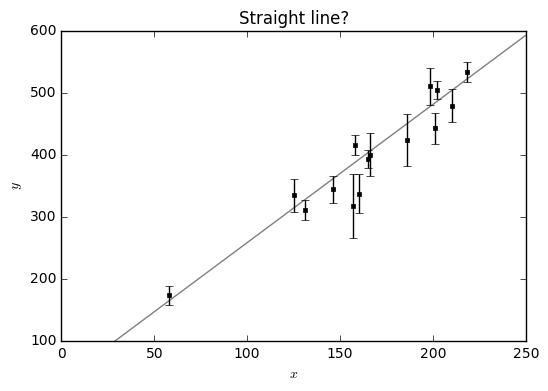

In [66]:
# Linear algebra: weighted least squares
N = len(x)
A = np.zeros((N,2))
A[:,0] = 1. / sigmay
A[:,1] =  x / sigmay
b = y / sigmay
theta,nil,nil,nil = np.linalg.lstsq(A, b)
plot_yerr(x, y, sigmay)
b_ls,m_ls = theta
print 'Least Squares (maximum likelihood) estimator:', b_ls,m_ls
plot_line(m_ls, b_ls);

## Short Cut #2: Laplace Approximation (Blackboard)
MacKay Chapter 27; 

It is often convenient to approximate a posterior distribution by something analytically more tractable, especially if the posterior needs to be further processed. The Laplace approximation $Q(\theta)$ of a PDF $P(\theta)$ does this by Taylor-approximating the logarithm $P(\theta)$ around its peak $x_0$ 

$\ln P(\theta) \approx \ln P(\theta_0) - \frac{c}{2}\left(\theta-\theta_0\right)^2 + ...$ with $c =-\frac{\partial^2}{\partial \theta^2} P(\theta)_{\theta_0}$:

Then $Q(\theta) = P(\theta_0) \exp[-\frac{c}{2}\left(\theta-\theta_0\right)^2]$ is a Gaussian, which can simplify calculations.

[The Matrix Cookbook](http://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) contains a list of useful Gaussian identities for this kind of manipulations.

Example: Derive Laplace approximation for $\ln(L((m,b)|\{x_i,y_i,\sigma_{y_i}\})\propto \sum_i -1/2(y_i-(b+m x_i) )^2/\sigma_{y_i}^2$.

# Monte Carlo Sampling Methods

In problems with higher dimensional parameter spaces, we need a more efficient way of approximating the posterior PDF - both when characterizing it in the first place, and then when doing integrals over that PDF (to get the marginalized PDFs for the parameters, or to compress them in to single numbers with uncertainties that can be easily reported). In most applications it's sufficient to approximate a PDF by a (relatively) small number of samples drawn from it; here we'll introduce a procedure for drawing samples from the posterior PDFs.

### Definition: Markov Chains

A sequence $p_1, p_2,...$ of random elements of some set is a _Markov chain_ if the conditional distribution of $p_{n+1}$ given $p_1,...,p_n$ depends on $X_n$ only. 
A Markov chain has _stationay transition probabilities_ if the conditional distribution of $X_{n+1}$ given $X_{n}$ does not depend on $n$.
A Markov Chain chain is _stationary_ if the conditional distribution $X_{n+1},...,X_{n+k}$ does not depend on $n$. 

*Some background how Markov Chain Monte Carlo sampling works on the blackboard* (if you don't want to take notes, see [Phil's thesis](http://www.slac.stanford.edu/~pjm/Site/CV_files/Marshall_PhDthesis.pdf) for a nice write up.)

In [73]:
def straight_line_posterior(x, y, sigmay, m, b):
    return np.exp(straight_line_log_posterior(x, y, sigmay, m, b))

In [74]:
def run_MC(m, mstep, b, bstep, nsteps, burn_in = 0):
  chain = []
  probs = []
  naccept = 0
    
  print 'Running MC for', nsteps, 'steps'

  # First point:
  L_old    = straight_line_log_likelihood(x, y, sigmay, m, b)
  p_old    = straight_line_log_prior(m, b)
  log_prob_old = L_old + p_old

  for i in range(nsteps+burn_in):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep

    # evaluate probabilities
    # prob_new = straight_line_posterior(x, y, sigmay, mnew, bnew)

    L_new    = straight_line_log_likelihood(x, y, sigmay, mnew, bnew)
    p_new    = straight_line_log_prior(mnew, bnew)
    log_prob_new = L_new + p_new

    if (np.exp(log_prob_new - log_prob_old) > np.random.uniform()):
        # accept
        m = mnew
        b = bnew
        L_old = L_new
        p_old = p_new
        log_prob_old = log_prob_new
        if (i > burn_in): #measure acceptance rate after burn-in only
            naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain.append((b,m))
    probs.append((L_old,p_old))
  print 'Acceptance fraction:', naccept/float(nsteps)
  return chain[burn_in:]

# initial m, b
m0,b0 = 0., 450.

# step sizes
mstep, bstep = 0.1, 10.
        
# how many steps?
nsteps = 5000

chain = run_MC(m0, mstep, b0, bstep, nsteps)

Running MC for 5000 steps
Acceptance fraction: 0.2922


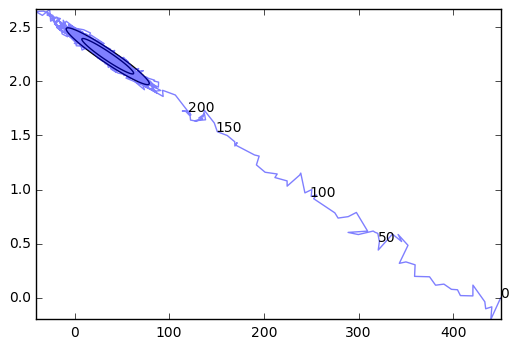

In [76]:
mm = [m for b,m in chain]
bb = [b for b,m in chain]
plt.clf()
# Plot trajectory of chain in (b,m) plane
plt.plot(bb, mm,linestyle='-',alpha=0.5)
for n in range(0,250,50):
 plt.text(bb[n],mm[n],"%d"%(n)) 
#overplot posterior contours from grid based estimate
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k',linewidth = 3)
plt.show()

## How does the outcome depend on all those parameter?
* Take a few minutes to explore how the chain depends on choices for starting point (m0,b0) and step sizes (mstep, bstep) in the cell below:

Running MC for 5000 steps
Acceptance fraction: 0.2162


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in exp


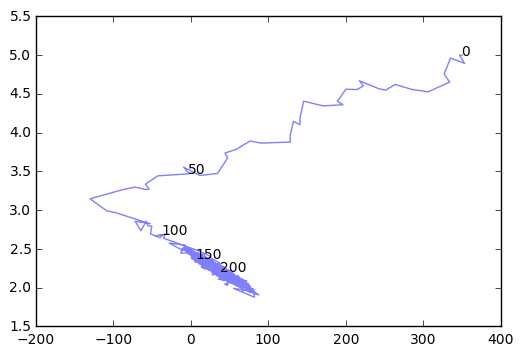

In [82]:
new_chain = run_MC(m0+5., mstep, b0-100, bstep*2., nsteps)

new_mm = [m for b,m in new_chain]
new_bb = [b for b,m in new_chain]
plt.clf()
plt.plot(new_bb, new_mm,linestyle='-',alpha=0.5)
for n in range(0,250,50):
 plt.text(new_bb[n],new_mm[n],"%d"%(n)) 
plt.show()

### Observation: Early parts of the chain depend strongly on starting point. Discard them!
* Use optional `burn_in = n` argument to remove first $n$ steps from chain.

Running MH for 5000 steps
Acceptance fraction: 0.3012


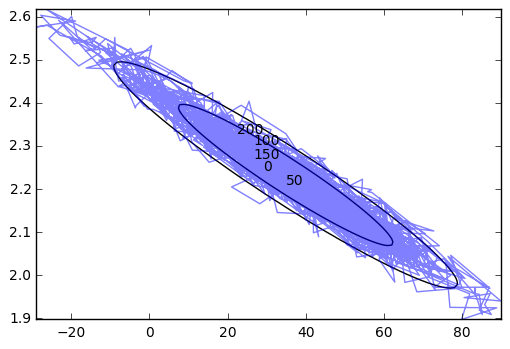

In [39]:
#Run chain again, now with burn_in = 1000
chain = run_MC(m0, mstep, b0, bstep, nsteps, burn_in = 1000)

# Redo the same plotting as before
mm = [m for b,m in chain]
bb = [b for b,m in chain]
plt.clf()
# Plot trajectory of chain in (b,m) plane
plt.plot(bb, mm,linestyle='-',alpha=0.5)
for n in range(0,250,50):
 plt.text(bb[n],mm[n],"%d"%(n)) 
#overplot posterior contours from grid based estimate
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k',linewidth = 3)
plt.show()

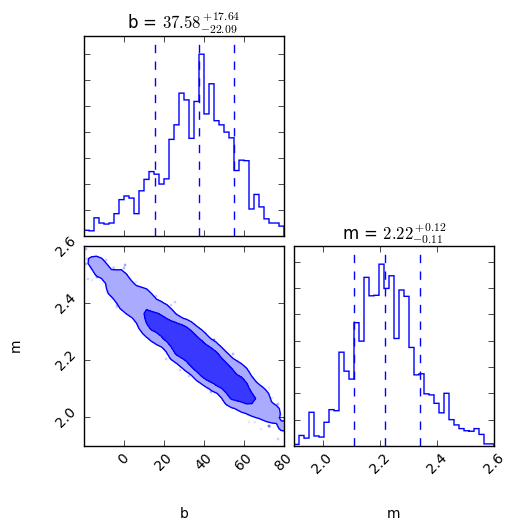

In [40]:
# 1 and 2D marginalised distributions:
import triangle
triangle.corner(chain, labels=['b','m'], range=[(blo,bhi),(mlo,mhi)],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.show()

## Convergence tests
We expect our chains to
eventually converge to the stationary distribution, which is also our
target distribution.
However, there is no guarantee that our chain has converged after
`nsteps`
draws.

*How do we know whether our chain has actually converged?*

We can never be sure, but there are several tests we can do, both
visual and statistical, to see if the chain _appears_ to be converged.

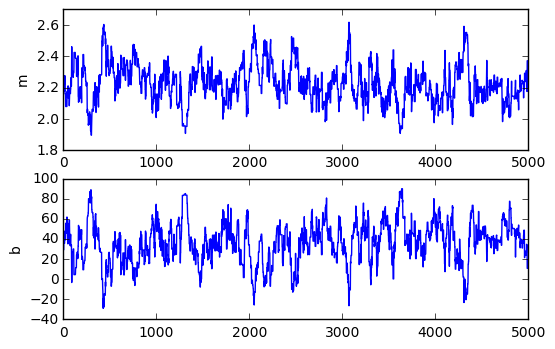

In [41]:
# Traces, for convergence inspection:
plt.clf()
plt.subplot(2,1,1)
plt.plot(mm, 'b-')
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'b-')
plt.ylabel('b')
plt.show()

### For comparison, run a second chain with different step sizes:

Running MH for 5000 steps
Acceptance fraction: 0.5102


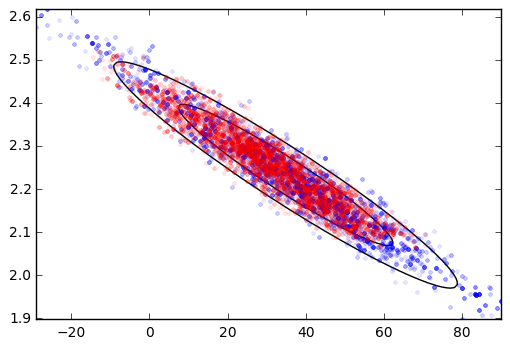

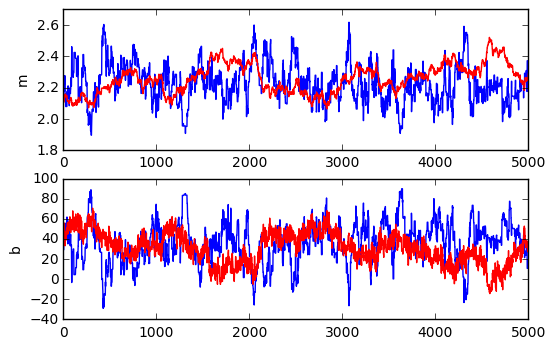

In [42]:
m0 = 1.0
b0 = 0.0
chain2 = run_MC(m0, mstep/10., b0, bstep, nsteps,burn_in = 1000)    
mm2 = [m for b,m in chain2]
bb2 = [b for b,m in chain2]
# Scatterplot of m,b posterior samples
plt.clf()
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')
#plt.gca().set_aspect((bhi-blo)/(mhi-mlo))
plt.plot(bb, mm, 'b.', alpha=0.1)
plt.plot(bb2, mm2, 'r.', alpha=0.1)
#plot_mb_setup()
plt.show()
# Traces, for convergence inspection:
plt.clf()
plt.subplot(2,1,1)
plt.plot(mm, 'b-')
plt.plot(mm2, 'r-')
#plt.ylim(mlo,mhi)
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'b-')
plt.plot(bb2, 'r-')
plt.ylabel('b')
#plt.ylim(blo,bhi)
plt.show()

Chain with smaller step size does not look stationary yet, but exhibists features comparable to chain length.

### How about a longer chain?
Easy test - as long as running longer chains is cheap.

Running MH for 50000 steps
Acceptance fraction: 0.50568


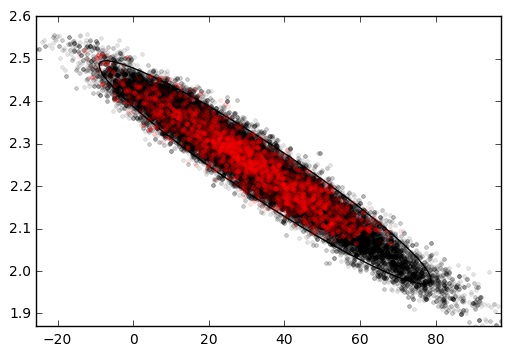

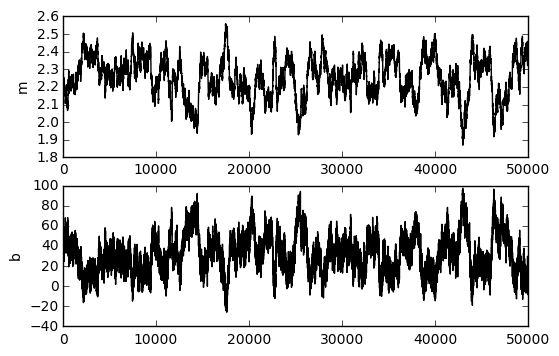

In [43]:
chain3 = run_MC(m0, mstep/10., b0, bstep, nsteps*10,burn_in = 1000)    
mm3 = [m for b,m in chain3]
bb3 = [b for b,m in chain3]
# Scatterplot of m,b posterior samples
plt.clf()
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')
plt.plot(bb3, mm3, 'k.', alpha=0.1)
plt.plot(bb2, mm2, 'r.', alpha=0.1)
plt.show()
# Traces, for convergence inspection:
plt.clf()
plt.subplot(2,1,1)
plt.plot(mm3, 'k-')
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb3, 'k-')
plt.ylabel('b')
plt.show()

## Diagnostic 1: Autocorrelation
One common way to asses convergence of a chain is by assessing the autocorrelations between draws of the parameter chain $\left\{\theta_i\right\}$:

The lag $k$ autocorrelation $\rho_k$ is the correlation between every draw and its $k$th lag:

$\rho_k = \frac{\sum_{i = 1}^{\mathrm{nsteps}-k}\left(\theta_{i} - \bar{\theta}\right)\left(\theta_{i+k} - \bar{\theta}\right)}{\sum_{i = 1}^{\mathrm{nsteps}}\left(\theta_{i} - \bar{\theta}\right)^2}$

One expects the $k$th lag autocorrelation to decrease as $k$ increases. If $\rho_k$ is still relatively high for high $k$ values, this indicates a high degree of correlation across the chain and slow mixing. 

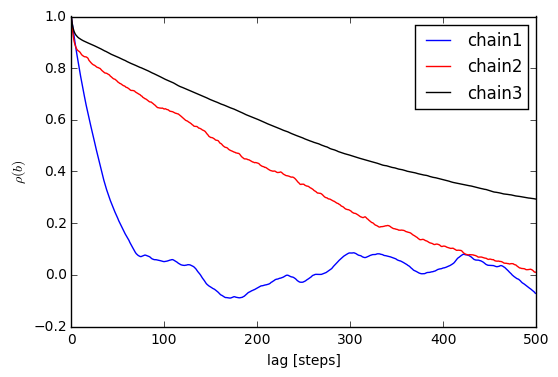

In [44]:
def autocor (chain, kmax):
    x = chain - np.mean(chain)
    cor = np.zeros(kmax)
    cor[0] =1.0
    for k in range(1,kmax):
      cor[k] = np.sum(x[0:-k]*x[k:])/np.sum(x*x)
    return cor

plt.clf()
kmax = 500
plt.plot(autocor(bb,kmax), 'b-', label = "chain1")
plt.plot(autocor(bb2,kmax), 'r-',label = "chain2")
plt.plot(autocor(bb3,kmax), 'k-',label = "chain3")
plt.ylabel(r'$\rho(b)$')
plt.xlabel('lag [steps]')
plt.ylim(-0.2,1.0)
plt.legend()
plt.show()

What's wrong with chain3?
* Running a longer chain does not reduce correlation as a function of lag
* But it does reduce correlation accross chain:

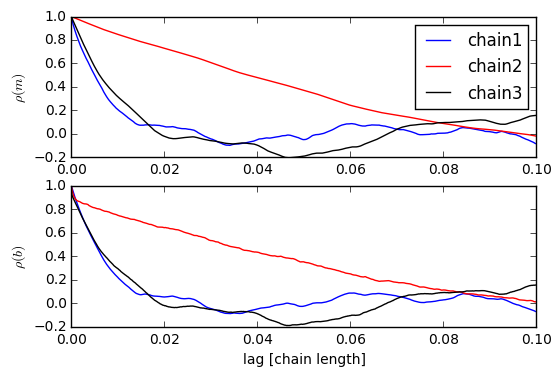

In [45]:
def autocor_scaled (chain, kmax):
    x = chain - np.mean(chain)
    cor = np.zeros(kmax)
    cor[0] = 1.0
    for k in range(1,kmax):
      cor[k] = np.sum(x[0:-k]*x[k:])/np.sum(x*x)
    return np.arange(0,kmax)/float(len(chain)),cor

plt.clf()
plt.subplot(2,1,1)
kmax = 500
r, cor = autocor_scaled(mm,kmax)
plt.plot(r,cor, 'b-', label = "chain1")
r, cor = autocor_scaled(mm2,kmax)
plt.plot(r,cor, 'r-', label = "chain2")
r, cor = autocor_scaled(mm3,10*kmax)
plt.plot(r,cor, 'k-', label = "chain3")
plt.ylabel(r'$\rho(m)$')
plt.xlim(0,.1)
plt.ylim(-0.2,1.0)
plt.legend()
plt.subplot(2,1,2)
r, cor = autocor_scaled(bb,kmax)
plt.plot(r,cor, 'b-')
r, cor = autocor_scaled(bb2,kmax)
plt.plot(r,cor, 'r-')
r, cor = autocor_scaled(bb3,10*kmax)
plt.plot(r,cor, 'k-')
plt.xlim(0,.1)
plt.ylim(-0.2,1.0)
plt.ylabel(r'$\rho(b)$')
plt.xlabel('lag [chain length]')
plt.show()

## Diagnostic 2: [Gelman-Rubin (1992)](https://projecteuclid.org/euclid.ss/1177011136) Statistic
This diagnostic uses multiple chains to check for lack of convergence, and is based on the notion that if multiple chains have converged, by definition they should appear very similar to one another; if not, one or more of the chains has failed to converge.
It compares the *between-chain variance*, $B$, and *within-chain variance*, $W$, and assesses whether they are different enough to worry about convergence. 

* 1) Run $M\ge 2$ chains of length n with *different* starting points
* 2) Calculate the within-chain variance $W$, and between-chain variance $B$
* 3) Calculate the estimated variance of the parameter as a weighted sum of the within-chain and between-chain variance
* 4) Calculate the *potential scale reduction factor* $\hat{R}$

In detail: 
* 2a) $W = \frac{1}{m}\sum_{J=1}^{M} s_J^2$ with $s_J^2= \frac{1}{n-1}\sum_{i=1}^n\left(\theta_{iJ}- \bar{\theta}_{J}\right)^2$ the (0-lag) variance in each chain
* 2b) $B = \frac{n}{m-1}\sum_{J=1}^{M}\left(\bar{\theta}_{J} -\bar{\theta}\right)^2$
* 3) $\hat{\mathrm{Var}}(\theta) = \frac{n-1}{n} V +\frac{1}{n}B$. This overestimates
the true variance if the starting values are overdispersed, but is unbiased if the starting distribution equals
the stationary distribution.
* 4) $\hat{R} = \sqrt{\frac{\hat{\mathrm{Var}}(\theta)}{W}}$ 

$\hat{R}$ is an estimate of the potential reduction in the scale of $\theta$ as the number of simulations tends to infinity. In practice, we look for values of $\hat{R}$  close to one (say, less than 1.1).



In [46]:
def gelmanrubin(chains):
    M = chains.shape[0]
    N = chains.shape[1]
    thetaJ = np.mean(chains,axis =1)
    thetabar = np.mean(chains)
    sJ = np.zeros(M)
    for i in range(0,M):
        sJ[i] = 1./(N-1.0)*np.sum(np.power(chains[i,:]-thetaJ[i],2.))
    W = 1./float(M)*np.sum(sJ)
    B = float(N)/(M-1.)*np.sum(np.power(thetaJ-thetabar,2.0))
    vartheta = float(N-1)/float(N)*W +B/float(N)
    return np.sqrt(vartheta/W)

In [47]:
M = 10
burnin = 1000
nsteps = 1000

chains_m = np.zeros((M,nsteps))
chains_b = np.zeros((M,nsteps))
for J in range(0,M):
    m0  = 5.*np.random.uniform()
    b0  = 500.*np.random.uniform()
    chaini = run_MC(m0, mstep, b0, bstep, nsteps, burn_in = burnin)
    chains_m[J,:] = [m for b,m in chaini]
    chains_b[J,:] = [b for b,m in chaini]

print "\n\nR(m) = %f" %(gelmanrubin(chains_m))
print "R(b) = %f" %(gelmanrubin(chains_b))

Running MH for 1000 steps
Acceptance fraction: 0.288
Running MH for 1000 steps
Acceptance fraction: 0.279
Running MH for 1000 steps
Acceptance fraction: 0.297
Running MH for 1000 steps
Acceptance fraction: 0.296
Running MH for 1000 steps
Acceptance fraction: 0.264
Running MH for 1000 steps
Acceptance fraction: 0.288
Running MH for 1000 steps
Acceptance fraction: 0.315
Running MH for 1000 steps
Acceptance fraction: 0.29
Running MH for 1000 steps
Acceptance fraction: 0.311
Running MH for 1000 steps
Acceptance fraction: 0.253


R(m) = 1.050041
R(b) = 1.051543


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in exp


In [ ]:
As a test, add in one chain with smaller step sizes which is unlikely to be converged:

In [48]:
chain = run_MC(m0, mstep/10., b0, bstep/20., nsteps, burn_in = burnin)
chains_m[M-1,:] = [m for b,m in chain]
chains_b[M-1,:] = [b for b,m in chain]
print "\n\nR(m) = %f" %(gelmanrubin(chains_m))
print "R(b) = %f" %(gelmanrubin(chains_b))

Running MH for 1000 steps
Acceptance fraction: 0.867


R(m) = 1.627902
R(b) = 1.671437


## Summary
In this lecture, you encountered different methods to characterize PDFs based on the example of fitting a linear model to data point:
* Recap from last week: evalute PDF on a grid
* Least Squares Fitting, an example for Maximum Likelihood Estimators
* Basic MCMC: how ii works, and how to check for convergence